# Test and Trial on Gaussian Mixture Distribution.

## Functions

In [1]:
%matplotlib inline

import sys
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.contrib.distributions import (
    Categorical, NormalWithSoftplusScale, Mixture)

from nn4post import InferenceBuilder
try:
    from tensorflow.contrib.distributions import Independent
except:
    print('WARNING - Your TF < 1.4.0.')
    from nn4post.utils.independent import Independent

/Users/shuiruge/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# For testing (and debugging)
SEED = 123456
tf.set_random_seed(SEED)
np.random.seed(SEED)

In [3]:
def make_log_posterior(target_c, target_mu, target_zeta):
  
    target_c = tf.convert_to_tensor(target_c)
    target_mu = tf.convert_to_tensor(target_mu)
    target_zeta = tf.convert_to_tensor(target_zeta)

    # -- Gaussian Mixture Distribution
    with tf.name_scope('posterior'):

      cat = Categorical(probs=target_c)
      components = [
          Independent(
              NormalWithSoftplusScale(target_mu[i], target_zeta[i])
          ) for i in range(target_c.shape[0])
      ]
      p = Mixture(cat, components)

      def log_posterior(theta):
          return p.log_prob(theta)

    return log_posterior

In [4]:
def shall_stop(loss_values, tolerance, n_means=20):
    """Returns `True` if the relative variance of loss-value in
    `loss_values` becomes smaller than `tolerance`, else `False`.
    The loss-value is smeared by its nearby `n_means` loss-values.
    """
    if len(loss_values) < 2 * n_means:
        return False

    else:
        previous_loss = np.mean(loss_values[-2*n_means:-n_means])
        current_loss = np.mean(loss_values[-n_means:])
        delta_loss = previous_loss - current_loss
        relative_delta_loss = abs( delta_loss / (current_loss + 1e-8) )

        if relative_delta_loss < tolerance:
            return True
        else:
            return False


def test(target_c, target_mu, target_zeta, init_var,
         tolerance=1e-2, n_iters=None, **inference_kwargs):
    """Test on Gaussian mixture distribution as the target.
    
    Args:
        target_c: Numpy array.
        target_mu: Numpy array.
        target_zeta: Numpy array.
        init_var: Dictionary with keys: "a", "mu", and "zeta" and
            values numpy arraies.
        XXX
            `n_iters` is more preferable than `tolerance`.
        inference_kwargs: Dictionary, as the kwargs (parameters)
            of `InferenceBuilder.__init__()`.
    
    Returns:
        Dictionary with keys: "loss", "a", "mu", and "zeta", and
        values the values at each iteration, collected in a list.
    """

    tf.reset_default_graph()

    log_p = make_log_posterior(target_c, target_mu, target_zeta)

    n_c, n_d = init_var['mu'].shape
    ib = InferenceBuilder(n_c, n_d, log_p, **inference_kwargs)
    
    a = tf.Variable(init_var['a'], dtype='float32')
    mu = tf.Variable(init_var['mu'], dtype='float32')
    zeta = tf.Variable(init_var['zeta'], dtype='float32')
    loss, gradients = ib.make_loss_and_gradients(a, mu, zeta)

    optimizer = tf.train.RMSPropOptimizer(0.05)
    #optimizer = tf.train.AdamOptimizer(0.005)
    train_op = optimizer.apply_gradients(gradients)
    
    init = tf.global_variables_initializer()

    with tf.Session() as sess:
        
        sess.run(init)

        test_result = {'loss': [], 'a': [], 'mu': [], 'zeta': []}
        step = 0
            
        def iter_body():
            
            nonlocal step

            _, loss_val, a_val, mu_val, zeta_val \
                = sess.run([train_op, loss, a, mu, zeta])

            test_result['loss'].append(loss_val)
            test_result['a'].append(a_val)
            test_result['mu'].append(mu_val)
            test_result['zeta'].append(zeta_val)
            
            step += 1
            if (step+1) % 100 == 0:
                print(step, loss_val)

        if n_iters:
            for i in range(n_iters):
                iter_body()
                
        else:
            while not shall_stop(test_result['loss'], tolerance):
                iter_body()
                
    return test_result

In [5]:
# Helpers

def softplus(x, limit=10.):
    return np.where(x<limit, np.log(1. + np.exp(x)), x)


def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

## Trials

### Trial 1: the Effect of $\beta$

When $\beta = 0$:

In [6]:
%%time

n_d = 2
ones = np.ones([n_d]).astype('float32')
target_c = np.array([0.7, 0.25, 0.05]).astype('float32')
target_mu = np.array([-2*ones, 0*ones, 2*ones]).astype('float32')
target_zeta = np.array([ones, ones, ones]).astype('float32')

n_c = 7
init_var = {
    'a': np.zeros([n_c]).astype('float32'),
    'mu': np.random.normal(0., 5., size=[n_c, n_d]).astype('float32'),
    'zeta': np.zeros([n_c, n_d]).astype('float32'),
}

init_var['mu'][0] = -2 * np.ones([n_d]).astype('float32')

test_result_0 = test(target_c, target_mu, target_zeta,init_var,
                     tolerance=1e-3, n_iters=500, beta=0.0)

99 0.14253569
199 0.013897896
CPU times: user 7min 43s, sys: 1min 1s, total: 8min 45s
Wall time: 3min 5s


When $\beta = 1$:

In [7]:
%%time

# The same configuration as `test_result_0`, but with `beta=1.0`
test_result_1 = test(target_c, target_mu, target_zeta,init_var,
                     tolerance=1e-3, n_iters=500, beta=1.0)

99 0.002339363
199 0.007887602
299 0.001521349
399 0.006501913
499 0.008797169
CPU times: user 19min 36s, sys: 3min 1s, total: 22min 38s
Wall time: 7min 19s


And display the result:

In [23]:
test_result_to_show = test_result_0

In [24]:
print(test_result_to_show['loss'][-30:])

[0.00695467, -0.006008148, 0.011356592, -0.003493309, -0.0036001205, -0.007409811, -0.0040745735, -0.0007624626, 0.017012596, 0.005335331, 0.003209591, -0.00037622452, 0.002897501, -0.0019845963, -0.0018732548, 0.0028936863, -0.0033762455, 0.0025360584, 0.0032007694, 0.0071783066, 0.0009441376, 0.0066661835, 0.0031051636, 0.0017533302, 0.008385658, 0.0012538433, 0.0060036182, -0.00027799606, 0.004256487, -0.0016946793]


In [25]:
print(softmax(test_result_to_show['a'][-1]), '\n')
print(test_result_to_show['mu'][-1], '\n')
print(test_result_to_show['zeta'][-1], '\n')

[0.5152563  0.01278522 0.05258612 0.19441491 0.00070004 0.09916727
 0.12509014] 

[[-1.6920393  -1.9116733 ]
 [-3.3646533  -1.8141397 ]
 [ 1.9164608   2.0286336 ]
 [-2.2659087  -2.2672427 ]
 [-1.9329877  -4.4803495 ]
 [ 0.03911677  0.310941  ]
 [ 0.1898911  -0.2624851 ]] 

[[ 1.0464882   1.0102983 ]
 [ 0.33415052  0.30113423]
 [ 1.0071946   1.0981168 ]
 [ 0.9067811   0.72158056]
 [ 0.9005389  -0.6449032 ]
 [ 0.79154336  1.0781412 ]
 [ 0.94154024  0.9734036 ]] 



In [26]:
def plot_trajectory(trajectory):
    """Plot 2D trajectory.
    
    Args:
        trajectory: List of 2D numpy array.
    """
    n_points = len(trajectory)
    x = [_[0] for _ in trajectory]
    y = [_[1] for _ in trajectory]
    delta_x = [x[i+1] - x[i] for i in range(n_points-1)]
    delta_y = [y[i+1] - y[i] for i in range(n_points-1)]
    plt.quiver(x, y, delta_x, delta_y)

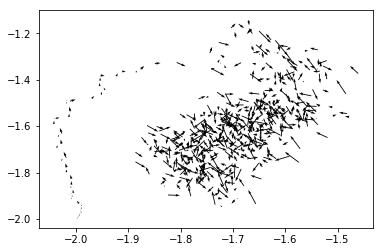

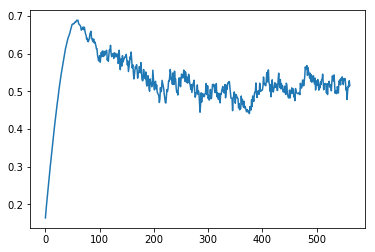

--------------


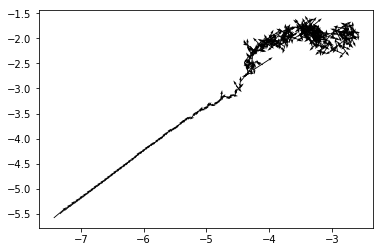

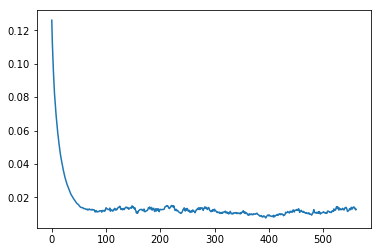

--------------


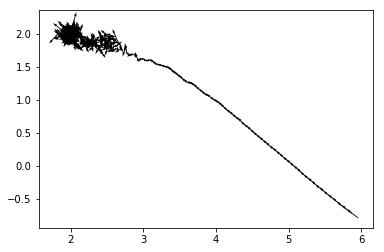

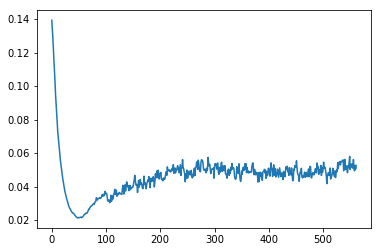

--------------


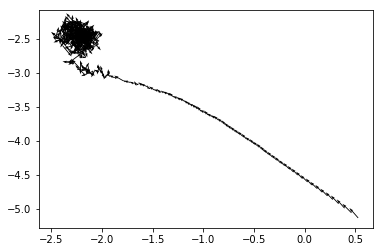

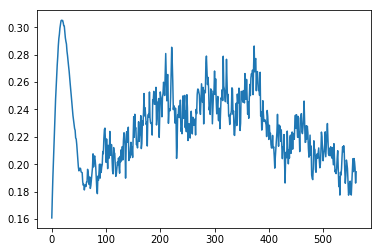

--------------


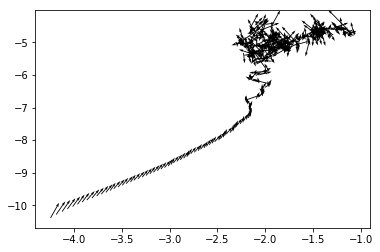

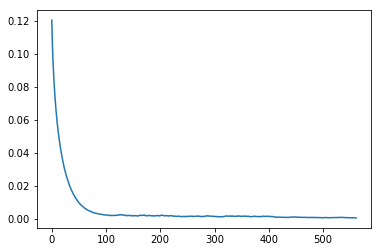

--------------


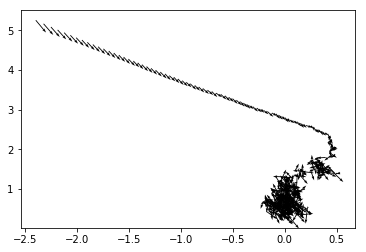

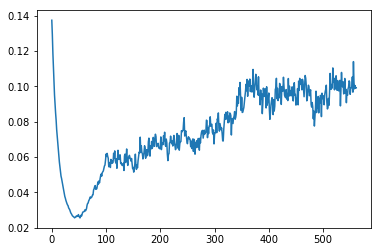

--------------


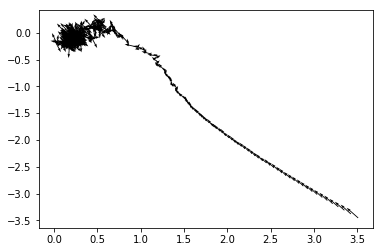

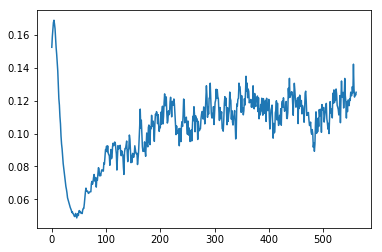

--------------


In [27]:
for i in range(n_c):
    
    plot_trajectory([_[i,:] for _ in test_result_to_show['mu']])
    plt.show()
    
    c = [softmax(_) for _ in test_result_to_show['a']]
    plt.plot([_[i] for _ in c])
    plt.show()
    
    print('--------------')